In [1]:
library(tidyverse) # metapackage of all tidyverse packages
library(ggthemes) # for ggplot themes
library(caret) # for modeling
library(mltools) # for one-hot encoding
library(data.table) # for data.table function
list.files(path = "../input/playground-series-s3e22")
options(warn=0)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, y

[1] "sample_submission.csv" "test.csv"              "train.csv"

In [2]:
# Read the train data
train_data <- read.csv('../input/playground-series-s3e22/train.csv')

train_data %>% head()
train_data %>% nrow()

# We have 29 variables to play with, including the 'id' and 'outcome' variable, the latter of which is our predicted value.

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,⋯,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,0,yes,adult,530001,38.1,132,24,cool,reduced,dark_cyanotic,⋯,57,8.5,serosanguious,3.4,yes,2209,0,0,no,died
2,1,yes,adult,533836,37.5,88,12,cool,normal,pale_cyanotic,⋯,33,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
3,2,yes,adult,529812,38.3,120,28,cool,reduced,pale_pink,⋯,37,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
4,3,yes,adult,5262541,37.1,72,30,cold,reduced,pale_pink,⋯,53,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
5,4,no,adult,5299629,38.0,52,48,normal,normal,normal_pink,⋯,47,7.3,cloudy,2.6,no,0,0,0,yes,lived
6,5,no,adult,529642,38.1,56,32,normal,normal,bright_pink,⋯,49,8.0,cloudy,2.8,no,0,0,0,yes,lived


[1] 1235

### Let's clean some data!

In [3]:
# The following columns all have data quality issues with the values 'none' and 'None' -- we will impute to 'None'

train_data <- train_data %>% mutate(abdominal_distention = ifelse(abdominal_distention == 'none', 'None', abdominal_distention), 
                      nasogastric_tube = ifelse(nasogastric_tube == 'none', 'None', nasogastric_tube), nasogastric_reflux = ifelse(nasogastric_reflux == 'none', 'None', nasogastric_reflux))

In [4]:
# Next, we'll make some factors out of the columns we just modified, in addition to a few others:
train_data <- train_data %>% mutate(temp_of_extremities = as.factor(temp_of_extremities), 
                                    peripheral_pulse = as.factor(peripheral_pulse), 
                                    mucous_membrane = as.factor(mucous_membrane), 
                                    capillary_refill_time = as.factor(capillary_refill_time), 
                                    peristalsis = as.factor(peristalsis), 
                                    abdominal_distention = as.factor(abdominal_distention), 
                                    nasogastric_tube = as.factor(nasogastric_tube), 
                                    nasogastric_reflux = as.factor(nasogastric_reflux), 
                                    rectal_exam_feces = as.factor(rectal_exam_feces), 
                                    abdomen = as.factor(abdomen), 
                                    abdomo_appearance = as.factor(abdomo_appearance), 
                                    surgical_lesion = as.factor(surgical_lesion),
                                    surgery = as.factor(surgery), 
                                    age = as.factor(age), 
                                    surgical_lesion = as.factor(surgical_lesion), 
                                    cp_data = as.factor(cp_data))

In [5]:
# Now we want to convert some columns from character to numeric, but first we need to assign 'none' values to NA, so we can later replace them with the column means.

train_data[train_data$rectal_temp == 'none',] <- NA
train_data[train_data$pulse == 'none',] <- NA
train_data[train_data$respiratory_rate == 'none',] <- NA
train_data[train_data$nasogastric_reflux_ph == 'none',] <- NA
train_data[train_data$packed_cell_volume == 'none',] <- NA
train_data[train_data$total_protein == 'none',] <- NA

In [6]:
# And then we want to convert them to numeric.

train_data <- train_data %>% mutate(rectal_temp = as.numeric(rectal_temp), 
                                    pulse = as.numeric(pulse), 
                                    respiratory_rate = as.numeric(respiratory_rate), 
                                    nasogastric_reflux_ph = as.numeric(nasogastric_reflux_ph), 
                                    packed_cell_volume = as.numeric(packed_cell_volume), 
                                    total_protein = as.numeric(total_protein), 
                                    abdomo_protein = as.numeric(abdomo_protein), 
                                    lesion_1 = as.numeric(lesion_1), 
                                    lesion_2 = as.numeric(lesion_2), 
                                    lesion_3 = as.numeric(lesion_3))

In [7]:
# For the lesion_ columns, we want to impute NAs to 0s
train_data <- train_data %>% mutate(lesion_1 = replace_na(lesion_1, 0), lesion_2 = replace_na(lesion_2, 0), lesion_3 = replace_na(lesion_3, 0))

train_data %>% filter(is.na(lesion_1) | is.na(lesion_2) | is.na(lesion_3)) %>% nrow() # check to make sure there are no NAs in the lesion columns

[1] 0

In [8]:
# Using the columns we imputed to NA, we now want to set those to the mean of their respective columns.
train_data <- train_data %>% mutate(across(c(rectal_temp, pulse, respiratory_rate, nasogastric_reflux_ph, packed_cell_volume, total_protein, abdomo_protein), ~replace_na(., mean(., na.rm=TRUE))))

In [9]:
# Taking a look at the pain values in both train & test, we see there are different values for what appear to be the same thing: slight & moderate
# We decied to impute the trainnig data value 'slight' to 'moderate'
train_data <- train_data %>% mutate(pain = as.factor(ifelse(pain == 'slight', 'moderate', pain)))

# We could go further and group with 'mild_pain', but for now we'll leave it.

In [10]:
# And finally, we make the predicted value a factor
train_data <- train_data %>% mutate(outcome = as.factor(outcome))

In [11]:
# We'll do a colSums looking for NAs -- we're clear!
colSums(is.na(train_data))

id               surgery                   age 
                    0                     0                     0 
      hospital_number           rectal_temp                 pulse 
                    0                     0                     0 
     respiratory_rate   temp_of_extremities      peripheral_pulse 
                    0                     0                     0 
      mucous_membrane capillary_refill_time                  pain 
                    0                     0                     0 
          peristalsis  abdominal_distention      nasogastric_tube 
                    0                     0                     0 
   nasogastric_reflux nasogastric_reflux_ph     rectal_exam_feces 
                    0                     0                     0 
              abdomen    packed_cell_volume         total_protein 
                    0                     0                     0 
    abdomo_appearance        abdomo_protein       surgical_lesion 
                    0                     0                     0 
             lesion_1              lesion_2              lesion_3 
                    0                     0                     0 
              cp_data               outcome 
                    0                     0

In [12]:
# Let's do the same to the test_data, although the test_data appears to have better data quality!

# Read the test data
test_data <- read.csv('../input/playground-series-s3e22/test.csv')

test_data %>% head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,⋯,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<int>,<int>,<int>,<chr>
1,1235,no,adult,534053,38.6,40,20,normal,normal,normal_pink,⋯,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
2,1236,yes,adult,528469,38.2,112,48,cool,reduced,bright_pink,⋯,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
3,1237,yes,adult,528178,37.7,66,12,cool,normal,bright_red,⋯,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
4,1238,no,adult,534784,37.1,88,20,cool,reduced,pale_cyanotic,⋯,distend_large,75.0,81.0,None,1.0,yes,1400,0,0,no
5,1239,yes,adult,529840,38.3,50,12,None,normal,bright_pink,⋯,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes
6,1240,yes,adult,530239,38.5,104,36,cool,normal,bright_red,⋯,distend_small,69.0,8.9,serosanguious,6.0,yes,2207,0,0,yes


In [13]:
# The following columns all have data quality issues with the values 'none' and 'None' -- we will impute to 'None'

test_data <- test_data %>% mutate(abdominal_distention = ifelse(abdominal_distention == 'none', 'None', abdominal_distention), 
                      nasogastric_tube = ifelse(nasogastric_tube == 'none', 'None', nasogastric_tube), nasogastric_reflux = ifelse(nasogastric_reflux == 'none', 'None', nasogastric_reflux))

In [14]:
# There don't appear to be the same 'None' / 'none' issues in the test data, which is great.
# Still need to make some columns factors
test_data <- test_data %>% mutate(temp_of_extremities = as.factor(temp_of_extremities), 
                                    peripheral_pulse = as.factor(peripheral_pulse), 
                                    mucous_membrane = as.factor(mucous_membrane), 
                                    capillary_refill_time = as.factor(capillary_refill_time), 
                                    pain = as.factor(pain), peristalsis = as.factor(peristalsis), 
                                    abdominal_distention = as.factor(abdominal_distention), 
                                    nasogastric_tube = as.factor(nasogastric_tube), 
                                    nasogastric_reflux = as.factor(nasogastric_reflux), 
                                    rectal_exam_feces = as.factor(rectal_exam_feces), 
                                    abdomen = as.factor(abdomen), 
                                    abdomo_appearance = as.factor(abdomo_appearance), 
                                    surgery = as.factor(surgery), 
                                    age = as.factor(age), 
                                    surgical_lesion = as.factor(surgical_lesion), 
                                    cp_data = as.factor(cp_data))

In [15]:
# If we sum the NAs across the columns, we don't get any -- that's great!!
colSums(is.na(test_data))

id               surgery                   age 
                    0                     0                     0 
      hospital_number           rectal_temp                 pulse 
                    0                     0                     0 
     respiratory_rate   temp_of_extremities      peripheral_pulse 
                    0                     0                     0 
      mucous_membrane capillary_refill_time                  pain 
                    0                     0                     0 
          peristalsis  abdominal_distention      nasogastric_tube 
                    0                     0                     0 
   nasogastric_reflux nasogastric_reflux_ph     rectal_exam_feces 
                    0                     0                     0 
              abdomen    packed_cell_volume         total_protein 
                    0                     0                     0 
    abdomo_appearance        abdomo_protein       surgical_lesion 
                    0                     0                     0 
             lesion_1              lesion_2              lesion_3 
                    0                     0                     0 
              cp_data 
                    0

In [16]:
# Our test_data now looks like this
test_data %>% head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,⋯,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,⋯,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<int>,<int>,<int>,<fct>
1,1235,no,adult,534053,38.6,40,20,normal,normal,normal_pink,⋯,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
2,1236,yes,adult,528469,38.2,112,48,cool,reduced,bright_pink,⋯,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
3,1237,yes,adult,528178,37.7,66,12,cool,normal,bright_red,⋯,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
4,1238,no,adult,534784,37.1,88,20,cool,reduced,pale_cyanotic,⋯,distend_large,75.0,81.0,None,1.0,yes,1400,0,0,no
5,1239,yes,adult,529840,38.3,50,12,None,normal,bright_pink,⋯,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes
6,1240,yes,adult,530239,38.5,104,36,cool,normal,bright_red,⋯,distend_small,69.0,8.9,serosanguious,6.0,yes,2207,0,0,yes


In [17]:
# From the training data, we see there are three possible outcomes:
train_data %>% select(outcome) %>% unique()

,outcome
,<fct>
1,died
2,euthanized
3,lived


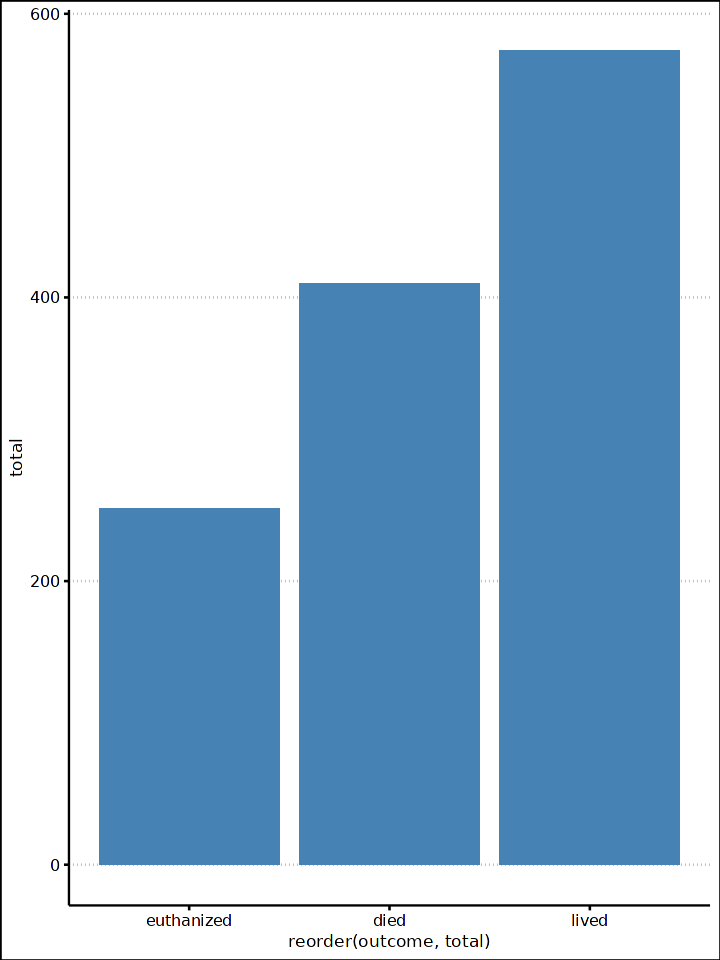

In [18]:
# How prevalent are each one in the data?
# Adjust plot size
options(repr.plot.width = 6, repr.plot.height =8)
train_data %>% group_by(outcome) %>% summarize(total = n()) %>% select(outcome, total) %>% ggplot(aes(x=reorder(outcome, total))) + geom_col(aes(y=total), fill = 'steelblue') + theme_clean()

In [19]:
# Or for a look at the percentages:
train_data %>% group_by(outcome) %>% summarize(total = n()/nrow(.))

# Less than half lived :(

outcome,total
<fct>,<dbl>
died,0.3319838
euthanized,0.2032389
lived,0.4647773


### Some interesting plots that may help during EDA...

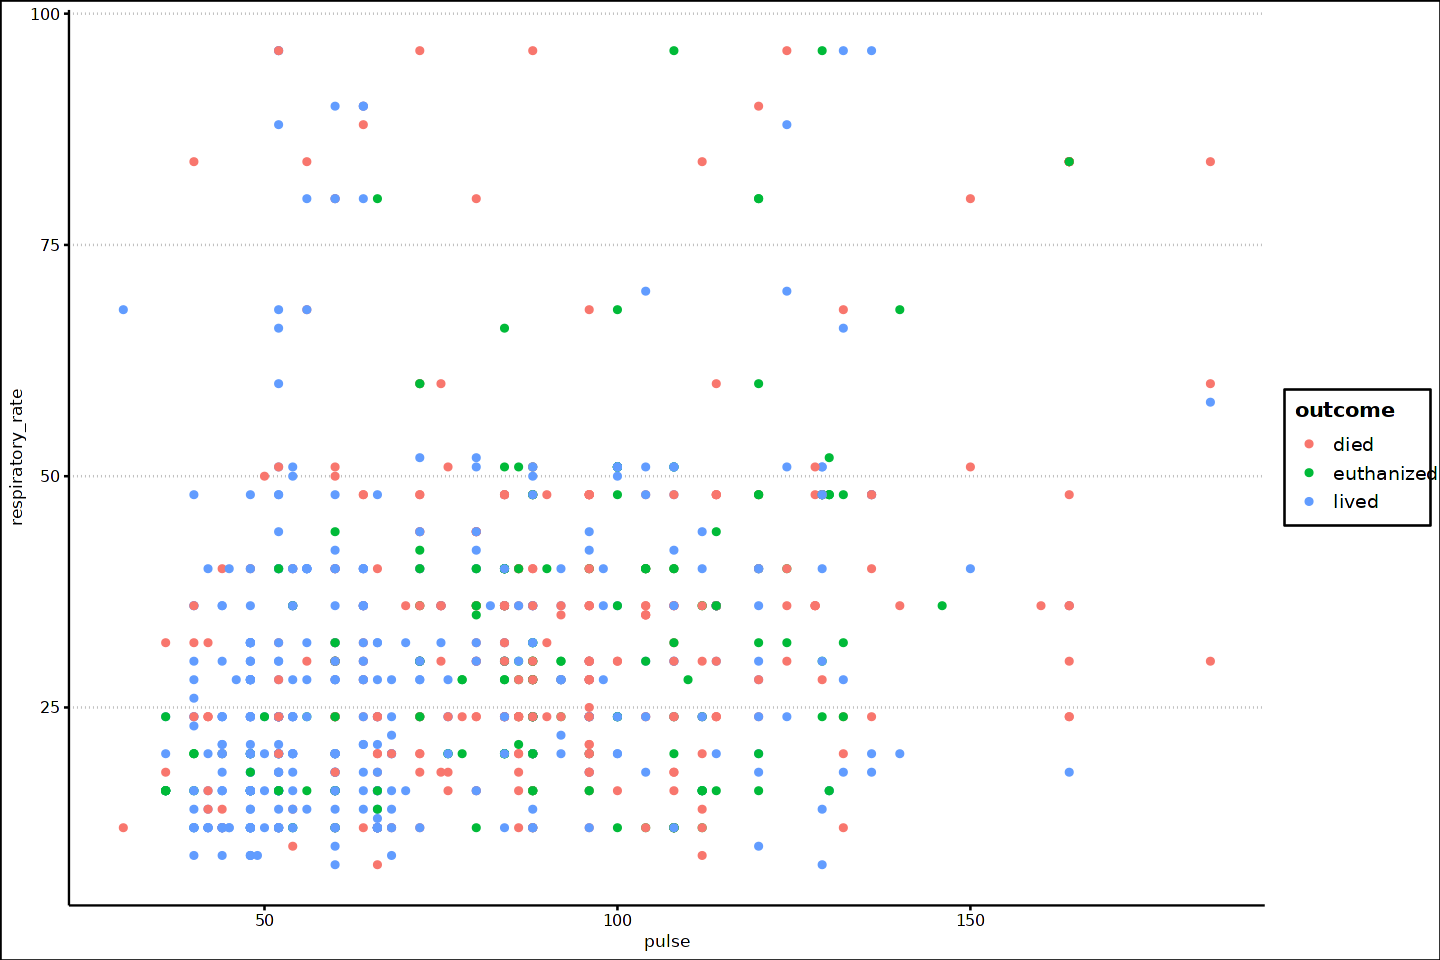

In [20]:
# Plot of respiratory rate, pulse, & outcome

# Adjust plot size
options(repr.plot.width = 12, repr.plot.height =8)
train_data %>% ggplot(aes(x=pulse, y=respiratory_rate)) + geom_point(aes(color = outcome)) + theme_clean()

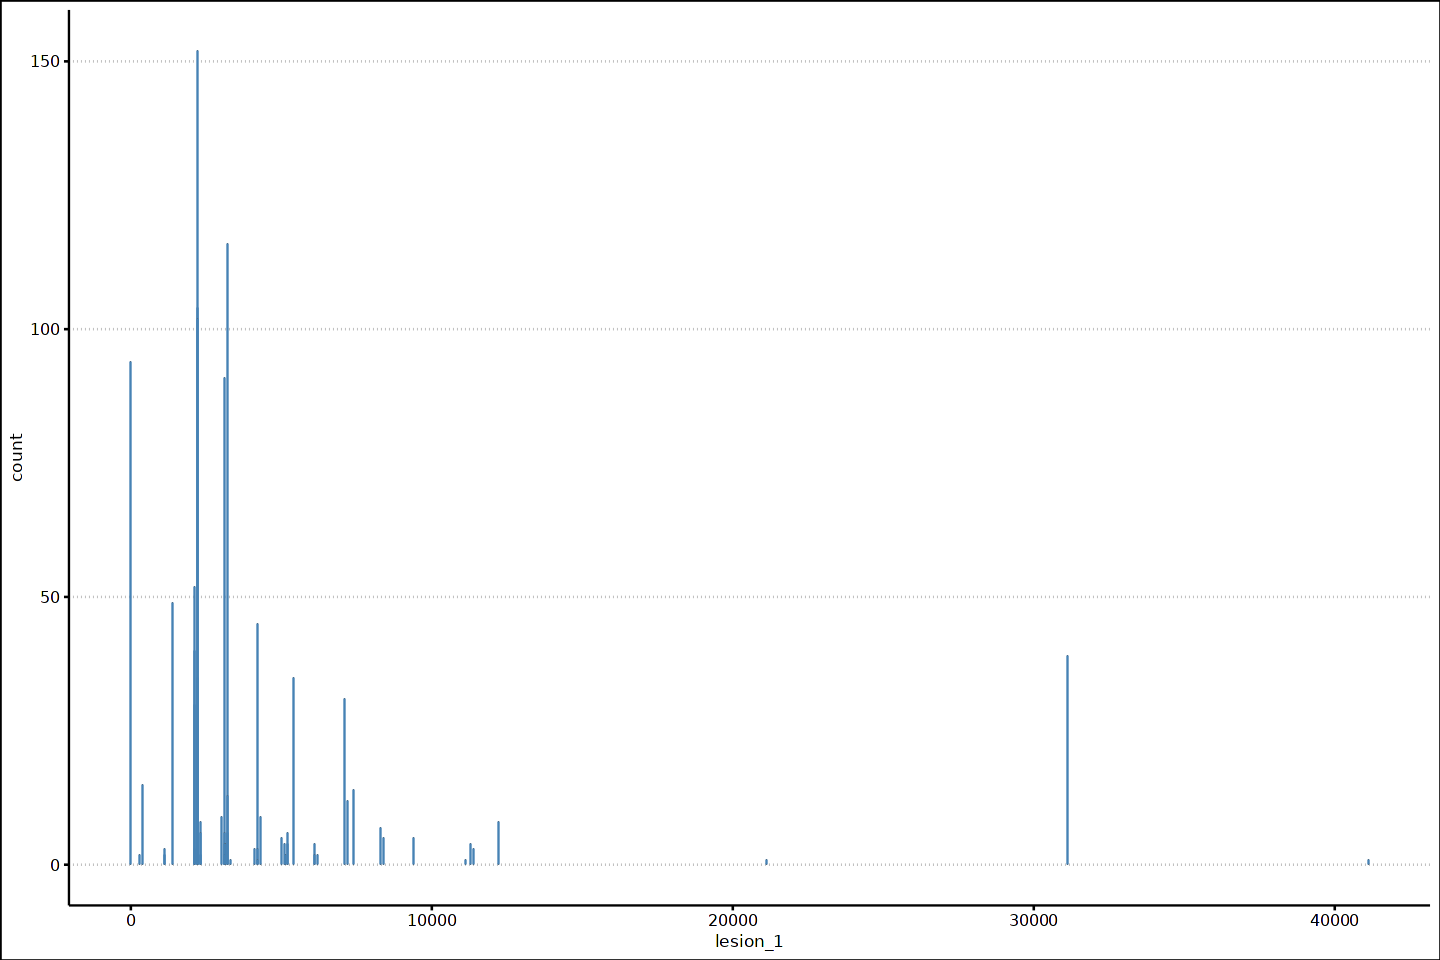

In [21]:
# Distribution of Lesion_1 values
# Adjust plot size
options(repr.plot.width = 12, repr.plot.height =8)
train_data %>% ggplot(aes(x=lesion_1)) + geom_bar(color='steelblue') + theme_clean()

[1] 4

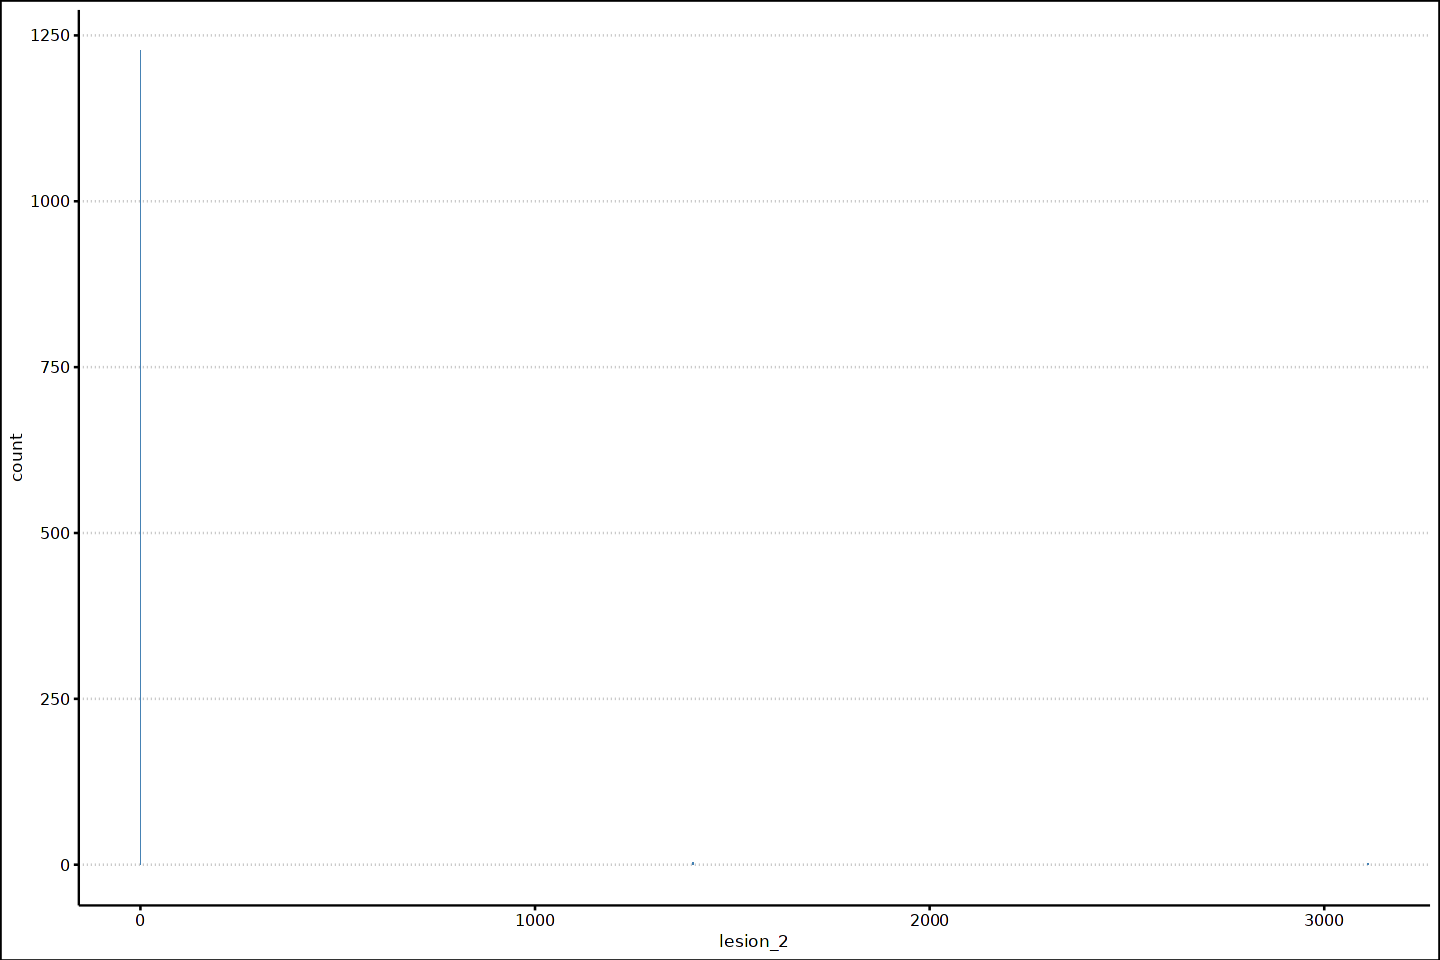

In [22]:
# Distribution of Lesion_2 values
# Adjust plot size
options(repr.plot.width = 12, repr.plot.height =8)
train_data %>% ggplot(aes(x=lesion_2)) + geom_bar(fill='steelblue') + theme_clean()

train_data %>% select(lesion_2) %>% unique() %>% nrow() # only 4 unique values for Lesion_2

[1] 2

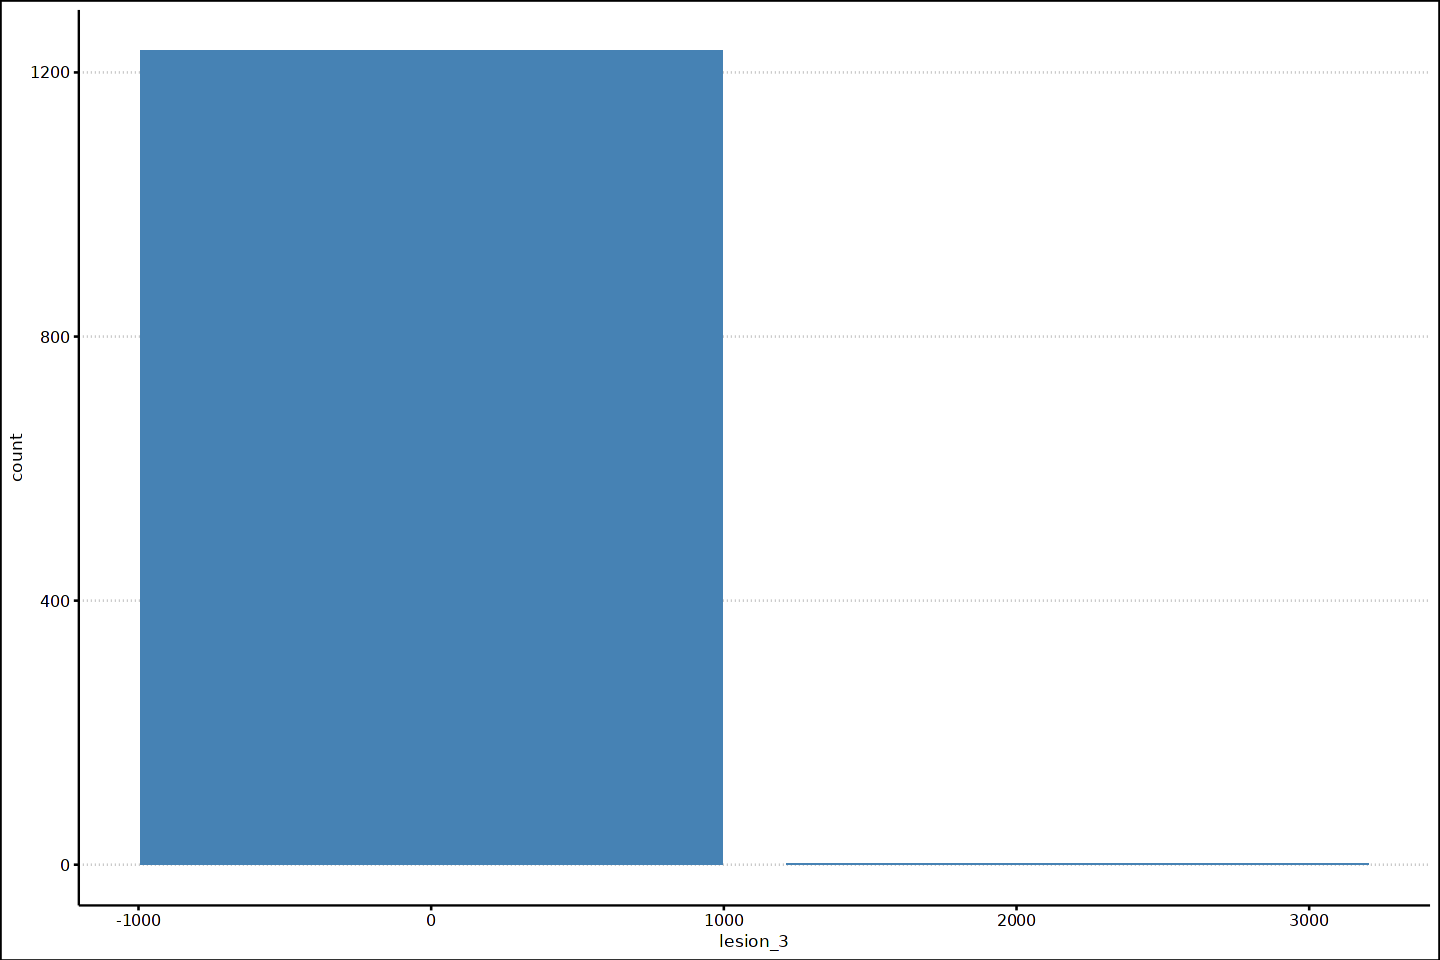

In [23]:
# Distribution of Lesion_3 values
# Adjust plot size
options(repr.plot.width = 12, repr.plot.height =8)
train_data %>% ggplot(aes(x=lesion_3)) + geom_bar(fill='steelblue') + theme_clean()

train_data %>% select(lesion_3) %>% unique() %>% nrow() # only 2 unique values for Lesion_3, with only one value of 2209, the remaining are 0

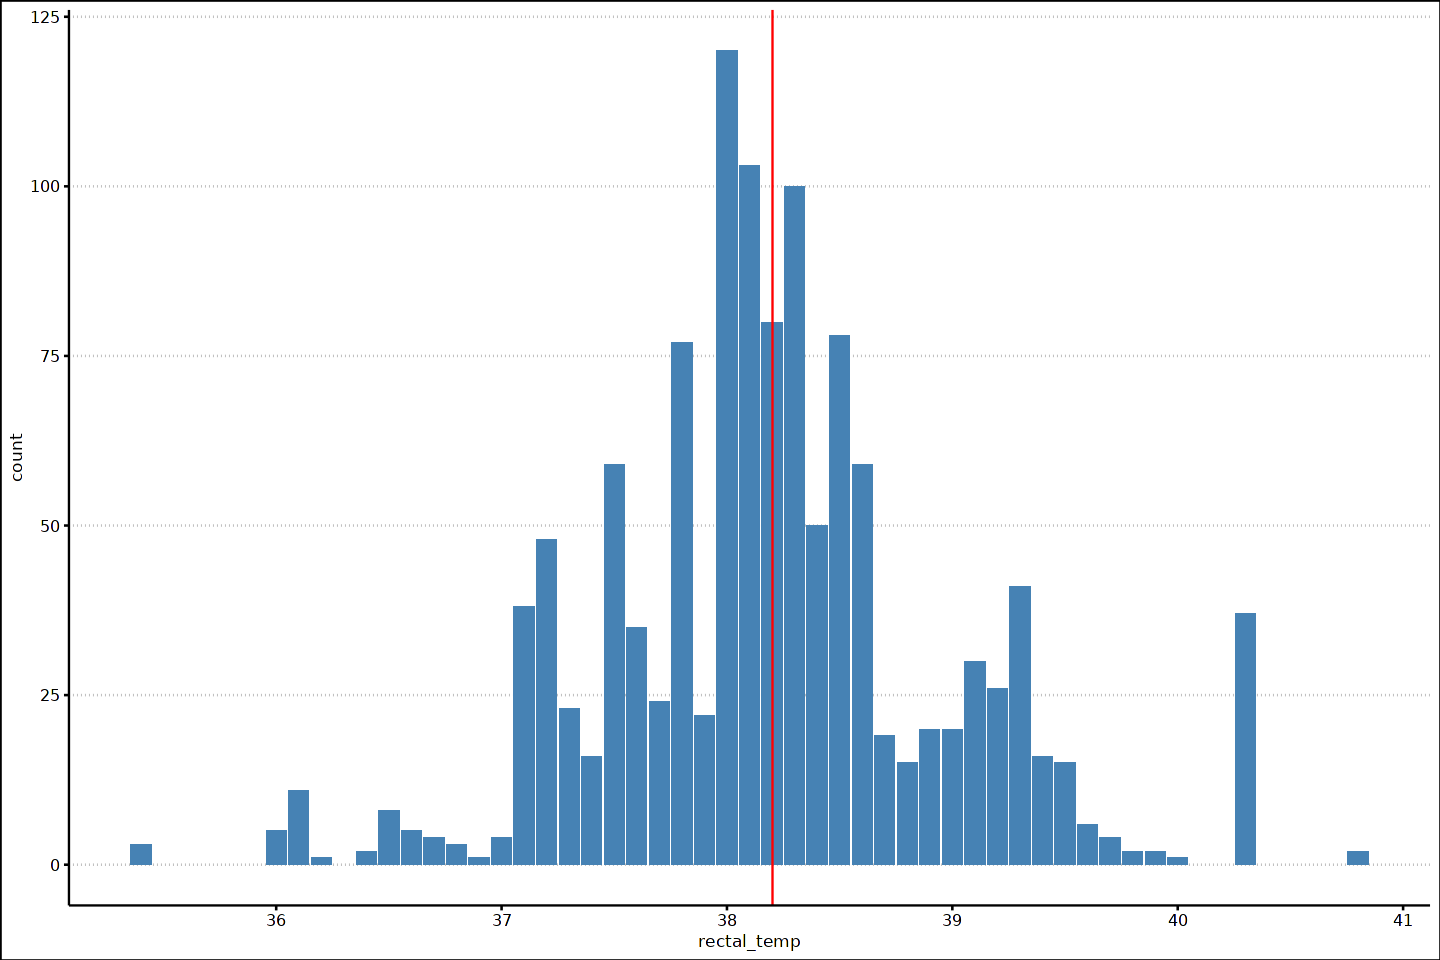

In [24]:
# Distribution of rectal_temp, with the mean plotted as a vertical red line
# Adjust plot size
options(repr.plot.width = 12, repr.plot.height =8)
mean_temp <- train_data %>% pull(rectal_temp) %>% mean()
train_data %>% ggplot(aes(x=rectal_temp)) + geom_bar(fill='steelblue')  + geom_vline(xintercept = mean_temp, color= 'red') + theme_clean()

### Let's try an xgbLinear submission:

In [25]:
# First, let's update some features based on testing
#str(train_data)
train_data <- train_data %>% mutate(abdominal_distention = ifelse(abdominal_distention == 'None',0,ifelse(abdominal_distention == 'slight',1,ifelse(abdominal_distention == 'moderate',2,4))))
test_data <- test_data %>% mutate(abdominal_distention = ifelse(abdominal_distention == 'None',0,ifelse(abdominal_distention == 'slight',1,ifelse(abdominal_distention == 'moderate',2,4))))

In [26]:
# Save the ids for the submission
test_data_ids <- test_data %>% select(id)

In [27]:
# Removing the id
train_data <- train_data %>% select(-id)
test_data <- test_data %>% select(-id)

In [28]:
# Creating the partitions
set.seed(1)
test_index <- createDataPartition(train_data$outcome, times = 1, p =.8, list = FALSE)
train_set <- train_data[test_index,]
test_set <- train_data[-test_index,]

In [29]:
xgb_grid <- expand.grid(
  nrounds= 150,
  eta=.3,
  lambda = .0001,
  alpha =0
)
xgb_trcontrol <- trainControl(
  method="cv",
  number = 10
)

In [30]:
# Training the model
model <- train(outcome ~ ., method = 'xgbLinear', trControl = xgb_trcontrol, data = train_data) #tuneGrid = xgb_grid, 

In [31]:
model

eXtreme Gradient Boosting 

1235 samples
  27 predictor
   3 classes: 'died', 'euthanized', 'lived' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1111, 1112, 1112, 1111, 1112, 1111, ... 
Resampling results across tuning parameters:

  lambda  alpha  nrounds  Accuracy   Kappa    
  0e+00   0e+00   50      0.7101757  0.5394197
  0e+00   0e+00  100      0.7190795  0.5531808
  0e+00   0e+00  150      0.7190795  0.5523829
  0e+00   1e-04   50      0.7093824  0.5391145
  0e+00   1e-04  100      0.7142080  0.5469719
  0e+00   1e-04  150      0.7166470  0.5500382
  0e+00   1e-01   50      0.7044912  0.5306940
  0e+00   1e-01  100      0.7142145  0.5456037
  0e+00   1e-01  150      0.7134015  0.5453907
  1e-04   0e+00   50      0.7061369  0.5321745
  1e-04   0e+00  100      0.7085563  0.5367437
  1e-04   0e+00  150      0.7166339  0.5488510
  1e-04   1e-04   50      0.7109822  0.5416667
  1e-04   1e-04  100      0.7174731  0.5508194
  1e-04   1e-04  150    

In [32]:
testing <- FALSE
if(testing){
    prediction <- predict(model,test_set)
    confusionMatrix(prediction, test_set$outcome, mode = 'everything', positive = '1')$byClass[,'F1'] %>% mean()
}else{
    # Predicting the test_set
    prediction <- predict(model,test_data)
    
}

In [33]:
# Create the submission_df
submission_df <- data.frame(student_id = test_data_ids, outcome = unlist(prediction))

# This is what our submission looks like
submission_df %>% head()

,id,outcome
,<int>,<fct>
1,1235,lived
2,1236,lived
3,1237,lived
4,1238,euthanized
5,1239,lived
6,1240,died


In [34]:
# Write, & cross your fingers!! (j/k)
write_csv(submission_df, 'submission.csv')